# Arima forecasting
Air pollution is a major issue in Hyderabad where I live. I am using the data taken from [aqicn.org](https://aqicn.org/) on the PM25 pollutant near my house in Hyderabad, India. I am using this data to build a model that will predict the PM25 air quality near my home. The training data can be found at [aqicn's api](https://aqicn.org/data-platform/register/)  

This model is deployed on a flask application at [harshaash.pythonanywhere.com](https://harshaash.pythonanywhere.com/) as a Rest API and you can find the past and current results at [hydpm25.aharsha.com/](http://hydpm25.aharsha.com/). The details on how to deploy the models can be found in the blog [ML Deployment in Flask](https://www.harshaash.com/Python/Machine%20learning%20as%20HTTP%20Request/).  

To find the theory of ARIMA in detail, read the blogs on [Stationarity](https://www.harshaash.com/R/time-series/), [Tests for stationarity](https://www.harshaash.com/R/Stationarity-tests/) and [ARIMA concept](https://www.harshaash.com/R/ARIMA/).

In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('hyderabad-us consulate-air-quality.csv', parse_dates=['date'])

## Vizualising time series
Historic data is present in the form of daily average since 2014 December.

In [2]:
data = data.sort_values('date')
data.columns = ['date', 'pm25']
data

,date,pm25
2295,2014-12-10,172
2296,2014-12-11,166
2297,2014-12-12,159
2298,2014-12-13,164
2299,2014-12-14,166
...,...,...
0,2021-11-01,155
1,2021-11-02,115
2,2021-11-03,67
3,2021-11-04,112


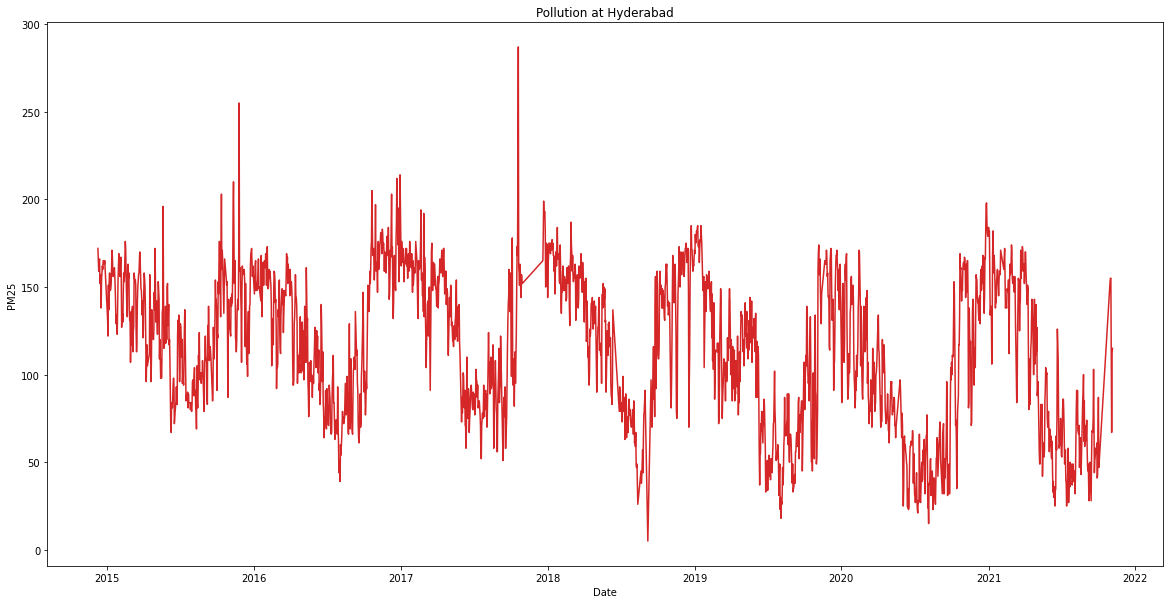

In [3]:
plt.figure(figsize=(20,10))
plt.plot(data.date, data.pm25, color='tab:red')
plt.gca().set(title='Pollution at Hyderabad', xlabel='Date', ylabel='PM25')
plt.show()

From this plot, we can see that pollution is higher during winter months while its lower during summer months. This effect is observed every year indicating a seasonal pattern in the data. There seems to be no increasing or decreasing trend in the data. This can be better visualised by decomposing the data into three components:  
1. Seasonal component: The component that varies with season  
2. Trend: Increasing or decreasing pattern  
3. Random component: Remaining component that has no pattern  

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data.pm25, model='additive', period = 365)

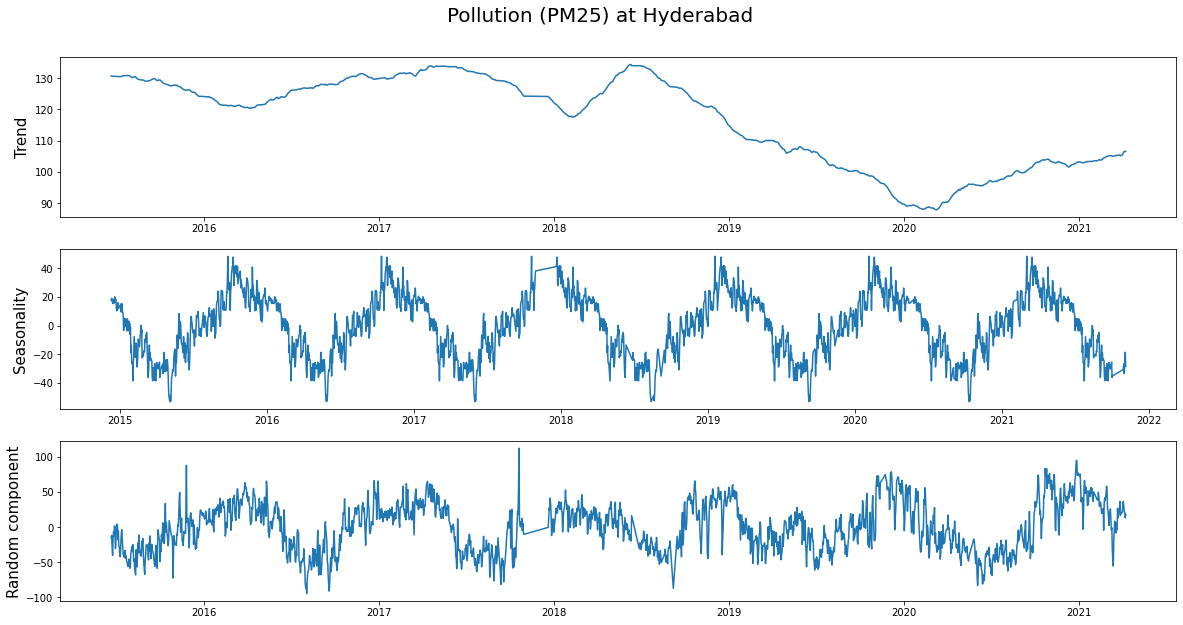

In [5]:
fs, axs = plt.subplots(3, figsize=(20,10))
plt.suptitle('Pollution (PM25) at Hyderabad', fontsize = 20, y = 0.95)

axs[0].plot(data.date, result.trend)
axs[1].plot(data.date, result.seasonal)
axs[2].plot(data.date, result.resid)

axs[0].set_ylabel('Trend', fontsize=15)
axs[1].set_ylabel('Seasonality', fontsize=15)
axs[2].set_ylabel('Random component', fontsize=15)

plt.show()

Looking at the trend, we can see how the pollution decreased during 2020 (probably due to covid) and is slowly rising as the country is getting back to its feet.

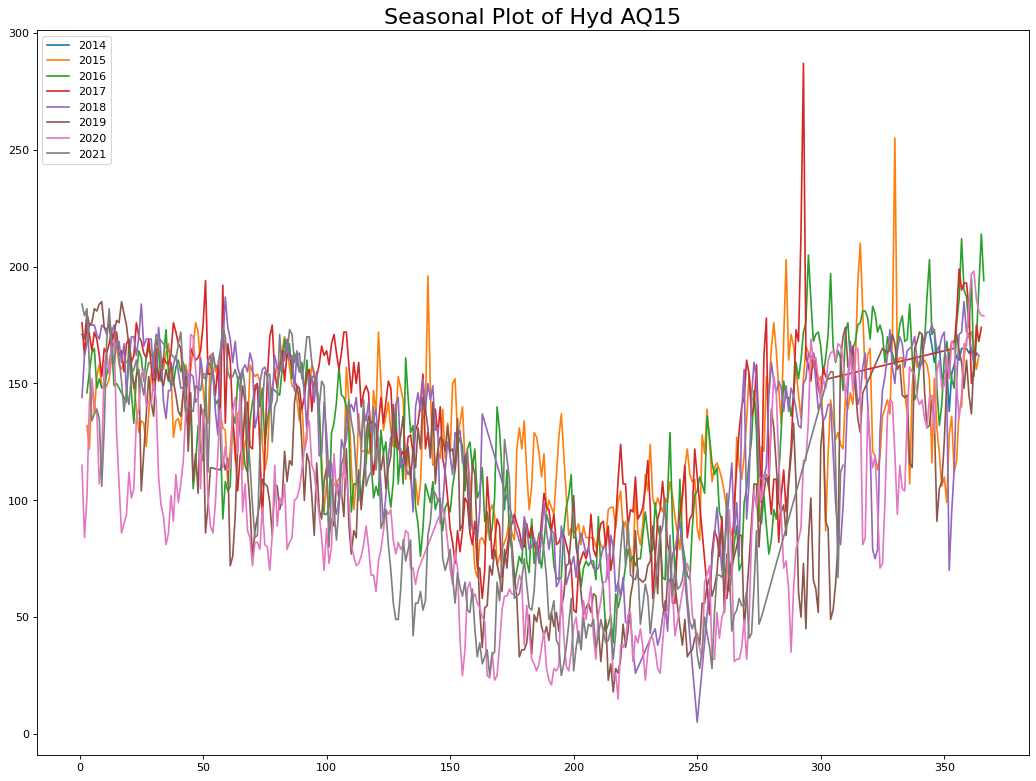

In [6]:
data['year'] = data.date.dt.year
data['day'] = data.date.dt.dayofyear

plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(data.year.unique()):
    plt.plot('day', 'pm25', data=data.loc[data.year==y, :], label = y)
plt.title("Seasonal Plot of Hyd AQ15", fontsize=20)
plt.legend(loc="upper left")

## Dickey Fuller unit root test
To find out if a time series is stationary, we can use the Dickey Fuller test. As discussed in the previous blog[], unit root stochastic process is another name for Random walk process. A random walk process can be written as  
$$ Y_t=\rho \times Y_{t−1} + \epsilon_t $$  
Where $\rho = 1$. If $|\rho|<1$ then the process represents Markov first order auto regressive model which is stationary. Only for $\rho=1$ we get non-stationary.    

The above equation can be alternatively written as
$$ Y_t - Y_{t-1} = \Delta Y_t = \delta \times Y_{t-1} + \epsilon_t $$
where $\delta = \rho -1$. For non-stationarity, the condition now becomes $\delta = 0$ the alternative hypothesis being $\delta < 0$. The null and alternate hypothesis are:  
$H_0: \delta = 0$ (Time series is non stationary)  
$H_1 : \delta < 0$ (Time series is stationary)  
Under this null hypothesis, $Y_{t-1}$ does not follow a normal distribution(or t-distribution).  

Dickey and Fuller have shown that for the above null and alternate hypothesis, the the estimated test statistic follows the $\tau$ statistic. If the hypothesis that $\delta=0$ is rejected, that is if the series is stationary, then we can use the t-test for further analysis.  

For the data, the Dickey Fuller tests give the following results

In [7]:
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(data.pm25)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.835594
p-value: 0.002563
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [8]:
# KPSS Test
result = kpss(data.pm25.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 1.318795
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


As the p-value is less than the cutoff (5%), we reject the Null hypothesis. The time series is stationary.  

## ACF and PACF plots


Figure(432x288)
Figure(432x288)


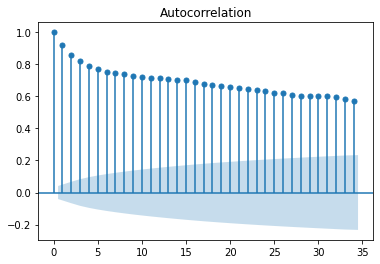

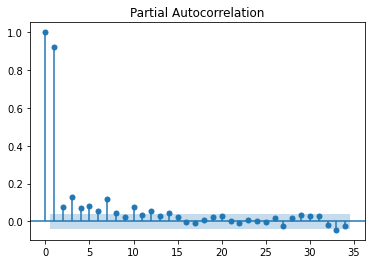

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print(plot_acf(data.pm25))
print(plot_pacf(data.pm25))

This indicates that the data is stationary. Another way to verify this is using the *pdarima* library to identify the lag at which the data will be stationary using adf, kpss and pp tests. While adf and pp are consistant with the above kpss test indicates that the data is stationary at d=1.  

In [10]:
from pmdarima.arima.utils import ndiffs
## Adf Test
print(ndiffs(data.pm25, test='adf'))

# KPSS test
print(ndiffs(data.pm25, test='kpss'))

# PP test:
print(ndiffs(data.pm25, test='pp'))

0
1
0


## Stepwise ARIMA
Performing stepwise arima in python to find the optimum p,d,q values.

In [11]:
import pmdarima as pm

# splitting into test and train
split_time = len(data)-365*2 # Latest two years is training, rest is test
time_train = data.date[:split_time]
x_train = data.pm25[:split_time]
time_valid = data.date[split_time:]
x_valid = data.pm25[split_time:]


model = pm.auto_arima(x_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=365,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality (as first trail)
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore', 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic


C:\ProgramData\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13312.056, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19910.319, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=18004.728, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13203.466, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=13204.966, Time=0.45 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13204.925, Time=0.45 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13249.558, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=13207.206, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=13196.527, Time=1.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=13270.440, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=13281.731, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=13197.878, Time=1.48 sec
 ARIMA(2,0,2)

The error metrics for the test data is:

In [12]:
# Getting accuracy metrics on test data
results_model = model.predict(n_periods = 365*2)
results_model

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
print('RMSE is ', sqrt(mean_squared_error(x_valid, results_model)))
print('MAE is ', mean_absolute_error(x_valid, results_model))

RMSE is  50.53383627717328
MAE is  43.4421801512105


From stepwise ARIMA, we see that the most optimal is p=2, d=0, and q=1 values with no significant seasonal component.This makes sense as any air pollutant generally stays in the air for a maximum of two days for Hyderabad wind and climatic patterns. So the effect of any sudden increase or decrease in pollutants (MA Component) exists for a day in the future. Also the pollution today is effected by the baseline pollution in the last two days (AR component).

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


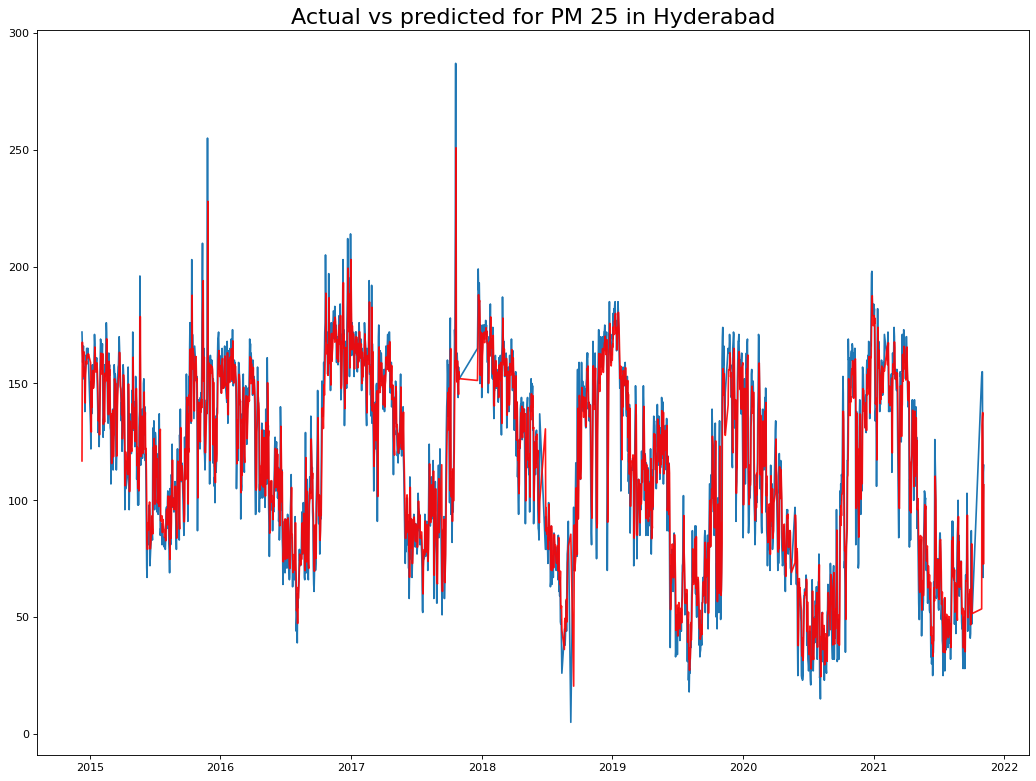

In [13]:
# Predicting on the complete data (test + train)
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(data.pm25, order=(2,0,1))
results_AR = model_arima.fit(disp=-1)
plt.figure(figsize=(16,12), dpi= 80)
plt.plot(data.date, data.pm25)
plt.plot(data.date, results_AR.fittedvalues, color='red', alpha = 0.9)
plt.title("Actual vs predicted for PM 25 in Hyderabad", fontsize=20)
plt.show()

From the residuals too, we can see no patterns, indicating that we have a good prediction.  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Figure(1440x720)


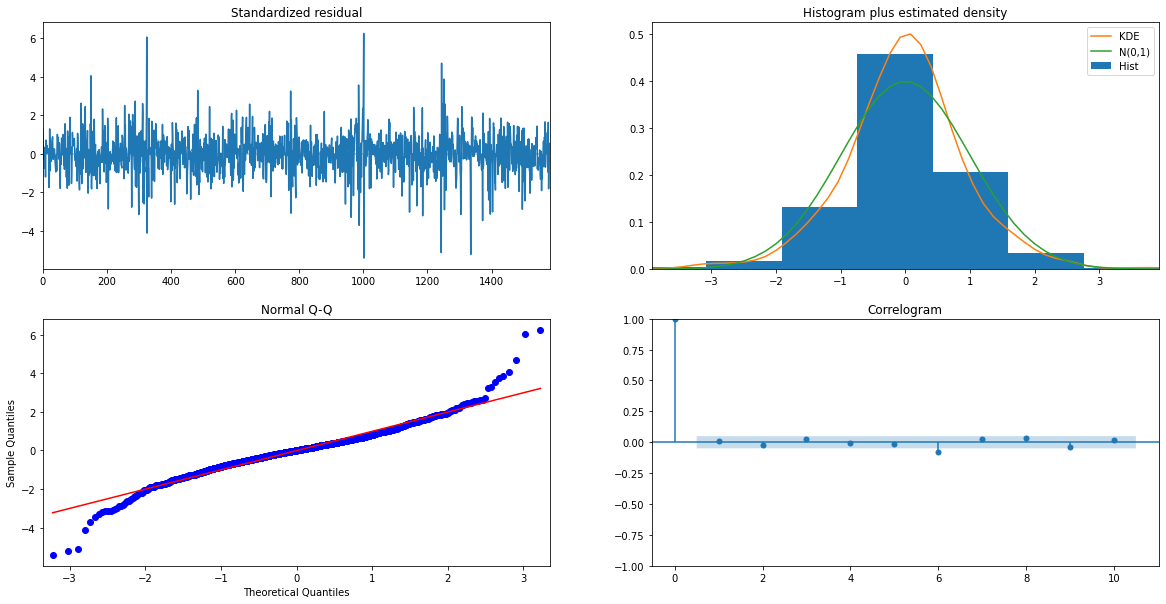

In [14]:
print(model.plot_diagnostics(figsize=(20,10)))

In the next blogs, we will implement deep learning (Like LSTM, RNN) and other methods on this data to deploy multiple models using various deployment methodologies.  